In [1]:
#!pip install nltk

In [2]:
# Run in python console

#nltk.download('stopwords')

In [3]:
# Run in terminal or command prompt
#!python -m spacy download en_core_web_sm

In [4]:
#!pip install pyLDAvis

In [5]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import nltk;
from pandasql import sqldf
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

# Enable logging for gensim - optional
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

#import warnings
#warnings.filterwarnings("ignore",category=DeprecationWarning)

In [6]:
import ast

def get_from_textlist(df):
    data_lemmatized = []
    print("--DATA_LEMMATIZED--")
    if 'text_list' in df.columns:
        list_data_lemmatized = df["text_list"].tolist()
        for lista in tqdm(list_data_lemmatized):
            data_lemmatized.append(ast.literal_eval(lista)
        )
    else:
        print('text_list not found')
        return
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)
    # Create Corpus
    texts = data_lemmatized
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    return corpus, id2word, data_lemmatized

In [7]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    print("--LDA_MODELS--")
    for num_topics in tqdm(range(start, limit, step)):
        
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [8]:
def format_topics_documents(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(tqdm(ldamodel[corpus])):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate((row)):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

# requiere los archivos que estan en la carpeta dominant topic (subien2)

In [10]:
ORIGINAL_TOPIC = 8
filename = f'./dominant_topics/dominant_topic{ORIGINAL_TOPIC}.csv'
df = pd.read_csv(filename)
corpus, id2word, data_lemmatized = get_from_textlist(df)
# Can take a long time to run.
limit=10; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start, limit=limit, step=1)

--DATA_LEMMATIZED--


100%|███████████████████████████████████████| 482/482 [00:00<00:00, 5452.61it/s]


--LDA_MODELS--


100%|█████████████████████████████████████████████| 8/8 [00:22<00:00,  2.76s/it]


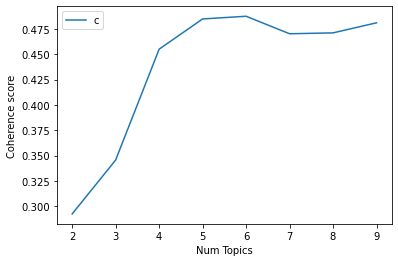

In [11]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [12]:
# Print the coherence scores
for i, (m, cv) in enumerate(zip(x, coherence_values)):
    print(f" [{i}] Num Topics = {m}  has Coherence Value of {cv:.4f}")

 [0] Num Topics = 2  has Coherence Value of 0.2924
 [1] Num Topics = 3  has Coherence Value of 0.3456
 [2] Num Topics = 4  has Coherence Value of 0.4550
 [3] Num Topics = 5  has Coherence Value of 0.4849
 [4] Num Topics = 6  has Coherence Value of 0.4875
 [5] Num Topics = 7  has Coherence Value of 0.4702
 [6] Num Topics = 8  has Coherence Value of 0.4711
 [7] Num Topics = 9  has Coherence Value of 0.4811


In [13]:
# elegir
optimo = 3
optimal_model = model_list[optimo]
optimal_ntopics = len(model_list[optimo].get_topics())

In [14]:
df_topic_sents_keywords = format_topics_documents(ldamodel=optimal_model,
                                                  corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'text_list']
df_dominant_topic.head(10)

100%|████████████████████████████████████████| 482/482 [00:01<00:00, 267.35it/s]


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,text_list
0,0,2.0,0.5849,"vecino, sector, agua, hacer, lugar, proyecto, ...","[grave, derechos, agua, hidroelectrico, aysen,..."
1,1,2.0,0.9990,"vecino, sector, agua, hacer, lugar, proyecto, ...","[alcalde, quilpue, zona, siniestrada, incendio..."
2,2,3.0,0.4654,"proyecto, obra, nuevo, regional, millón, ano, ...","[proyectar, febrero, entregar, mastil, soporta..."
3,3,2.0,0.9963,"vecino, sector, agua, hacer, lugar, proyecto, ...","[comunidad, indigén, pedir, moncul, acusar, de..."
4,4,2.0,0.6527,"vecino, sector, agua, hacer, lugar, proyecto, ...","[habilitar, transito, puente_mecano, reemplaza..."
5,5,4.0,0.9902,"droga, kilo, planta, drogo, decomiso, millón, ...","[caer, arico, banda, narco, liderado, capital,..."
6,6,2.0,0.9267,"vecino, sector, agua, hacer, lugar, proyecto, ...","[preparar, alternativo, familia, escasez, agua..."
7,7,2.0,0.7161,"vecino, sector, agua, hacer, lugar, proyecto, ...","[pedir, denuncia, relleno, gaviota, valdivia, ..."
8,8,2.0,0.9985,"vecino, sector, agua, hacer, lugar, proyecto, ...","[polemica, ecologico, santuario, hualpen, exji..."
9,9,2.0,0.8622,"vecino, sector, agua, hacer, lugar, proyecto, ...","[pesquisar, nuevamente, vertimiento, desecho, ..."


In [15]:
#ver los keywords de cada topico
from my_funcs import get_df_keywords
get_df_keywords(optimal_model, optimal_ntopics)

,0,1,2,3,4
0,condominio,comuna,vecino,proyecto,droga
1,puerto_vara,region,sector,obra,kilo
2,propiedad,distrito,agua,nuevo,planta
3,ordenar,común,hacer,regional,drogo
4,inmobiliario,biobio,lugar,millón,decomiso
5,antofagasta,metropolitano,proyecto,ano,millón
6,abogado,region_metropolitán,decir,avance,marihuán
7,tronco,millón,ano,construccion,operativo
8,alto,alcalde,zona,iniciativo,trafico
9,ofrecer,programa,municipio,region,mas


In [16]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,text_list
0,0,2.0,0.5849,"vecino, sector, agua, hacer, lugar, proyecto, ...","[grave, derechos, agua, hidroelectrico, aysen,..."
1,1,2.0,0.9990,"vecino, sector, agua, hacer, lugar, proyecto, ...","[alcalde, quilpue, zona, siniestrada, incendio..."
2,2,3.0,0.4654,"proyecto, obra, nuevo, regional, millón, ano, ...","[proyectar, febrero, entregar, mastil, soporta..."
3,3,2.0,0.9963,"vecino, sector, agua, hacer, lugar, proyecto, ...","[comunidad, indigén, pedir, moncul, acusar, de..."
4,4,2.0,0.6527,"vecino, sector, agua, hacer, lugar, proyecto, ...","[habilitar, transito, puente_mecano, reemplaza..."
...,...,...,...,...,...
477,477,2.0,0.7114,"vecino, sector, agua, hacer, lugar, proyecto, ...","[dirigente, campamento, funar, alcalde, grupo,..."
478,478,1.0,0.9962,"comuna, region, distrito, común, biobio, metro...","[plazo, permiso, vacación, llegar, mitad, revi..."
479,479,2.0,0.5664,"vecino, sector, agua, hacer, lugar, proyecto, ...","[construccion, cesfam, levantar, polemico, pro..."
480,480,3.0,0.3957,"proyecto, obra, nuevo, regional, millón, ano, ...","[programa, barrio, iniciar, primero, etapa, me..."


In [17]:
# que topicos vale la pena considerar
df_dominant_topic['Dominant_Topic'].value_counts()

2.0    312
3.0     90
4.0     43
1.0     34
0.0      3
Name: Dominant_Topic, dtype: int64

In [18]:
topic = 2
df_dominant_topic[df_dominant_topic['Dominant_Topic'] == float(topic)][['Document_No', 'text_list']]

,Document_No,text_list
0,0,"[grave, derechos, agua, hidroelectrico, aysen,..."
1,1,"[alcalde, quilpue, zona, siniestrada, incendio..."
3,3,"[comunidad, indigén, pedir, moncul, acusar, de..."
4,4,"[habilitar, transito, puente_mecano, reemplaza..."
6,6,"[preparar, alternativo, familia, escasez, agua..."
...,...,...
475,475,"[denunciar, mortandad, pez, especie, rio, duqu..."
476,476,"[polemica, lago_colico, denunciar, destruir, c..."
477,477,"[dirigente, campamento, funar, alcalde, grupo,..."
479,479,"[construccion, cesfam, levantar, polemico, pro..."


In [19]:
cats_dict = {#0 : '8-Ecología_y_Planeta',
             #1 : '8-Ecología_y_Planeta',
             2 : '8-Ecología_y_Planeta',
             #3 : '8-Ecología_y_Planeta',
             #4 : '10-Salud',
            }

for i in range(0, 5):
    if i not in cats_dict.keys():
        cats_dict[i] = np.nan
        
cats_dict

{2: '8-Ecología_y_Planeta', 0: nan, 1: nan, 3: nan, 4: nan}

In [20]:
poto()

NameError: name 'poto' is not defined

In [21]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,text_list
0,0,2.0,0.5849,"vecino, sector, agua, hacer, lugar, proyecto, ...","[grave, derechos, agua, hidroelectrico, aysen,..."
1,1,2.0,0.9990,"vecino, sector, agua, hacer, lugar, proyecto, ...","[alcalde, quilpue, zona, siniestrada, incendio..."
2,2,3.0,0.4654,"proyecto, obra, nuevo, regional, millón, ano, ...","[proyectar, febrero, entregar, mastil, soporta..."
3,3,2.0,0.9963,"vecino, sector, agua, hacer, lugar, proyecto, ...","[comunidad, indigén, pedir, moncul, acusar, de..."
4,4,2.0,0.6527,"vecino, sector, agua, hacer, lugar, proyecto, ...","[habilitar, transito, puente_mecano, reemplaza..."
...,...,...,...,...,...
477,477,2.0,0.7114,"vecino, sector, agua, hacer, lugar, proyecto, ...","[dirigente, campamento, funar, alcalde, grupo,..."
478,478,1.0,0.9962,"comuna, region, distrito, común, biobio, metro...","[plazo, permiso, vacación, llegar, mitad, revi..."
479,479,2.0,0.5664,"vecino, sector, agua, hacer, lugar, proyecto, ...","[construccion, cesfam, levantar, polemico, pro..."
480,480,3.0,0.3957,"proyecto, obra, nuevo, regional, millón, ano, ...","[programa, barrio, iniciar, primero, etapa, me..."


In [22]:
# combinar el df inicial con el que tiene los subptopicos
final_df = df.drop(columns=['Dominant_Topic', 'Keywords', 'text_list'])
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].astype(int)
final_df = pd.concat([final_df, df_dominant_topic[['Dominant_Topic', 'Keywords', 'text_list']]], axis=1)
final_df['Dominant_Topic'] = final_df['Dominant_Topic'].astype(int)

,id,content,Dominant_Topic,text_list
0,5165457,Grave: Derechos de agua de hidroeléctrica en A...,2,"[grave, derechos, agua, hidroelectrico, aysen,..."
1,4617608,Alcalde de Quilpué sobre zona siniestrada por ...,2,"[alcalde, quilpue, zona, siniestrada, incendio..."
2,191630,Proyectan para febrero de 2021 la entrega del ...,3,"[proyectar, febrero, entregar, mastil, soporta..."
3,178217,Comunidad indígena de Carahue pide protección ...,2,"[comunidad, indigén, pedir, moncul, acusar, de..."
4,31203,Habilitan el tránsito en el puente mecano que ...,2,"[habilitar, transito, puente_mecano, reemplaza..."
...,...,...,...,...
477,88406,"Dirigentes de campamentos ""funan"" a alcalde de...",2,"[dirigente, campamento, funar, alcalde, grupo,..."
478,13381897,Plazo de permisos de vacaciones llega a la mit...,1,"[plazo, permiso, vacación, llegar, mitad, revi..."
479,13384129,Construcción de Cesfam levanta polémica en Pro...,2,"[construccion, cesfam, levantar, polemico, pro..."
480,73969,"Programa ""Quiero mi Barrio"" inicia primera eta...",3,"[programa, barrio, iniciar, primero, etapa, me..."


In [24]:
#verificamos (al ojo) que el contenido coincida con text_list
final_df[['id', 'content', 'Dominant_Topic', 'text_list']]

,id,content,Dominant_Topic,text_list
0,5165457,Grave: Derechos de agua de hidroeléctrica en A...,2,"[grave, derechos, agua, hidroelectrico, aysen,..."
1,4617608,Alcalde de Quilpué sobre zona siniestrada por ...,2,"[alcalde, quilpue, zona, siniestrada, incendio..."
2,191630,Proyectan para febrero de 2021 la entrega del ...,3,"[proyectar, febrero, entregar, mastil, soporta..."
3,178217,Comunidad indígena de Carahue pide protección ...,2,"[comunidad, indigén, pedir, moncul, acusar, de..."
4,31203,Habilitan el tránsito en el puente mecano que ...,2,"[habilitar, transito, puente_mecano, reemplaza..."
...,...,...,...,...
477,88406,"Dirigentes de campamentos ""funan"" a alcalde de...",2,"[dirigente, campamento, funar, alcalde, grupo,..."
478,13381897,Plazo de permisos de vacaciones llega a la mit...,1,"[plazo, permiso, vacación, llegar, mitad, revi..."
479,13384129,Construcción de Cesfam levanta polémica en Pro...,2,"[construccion, cesfam, levantar, polemico, pro..."
480,73969,"Programa ""Quiero mi Barrio"" inicia primera eta...",3,"[programa, barrio, iniciar, primero, etapa, me..."


In [25]:
#guardamos solo los subtopicos que determinamos que tienen una categoria equivalente
final_df['category'] = final_df.apply(lambda row : cats_dict[row.Dominant_Topic], axis=1)
final_df = final_df[final_df['category'].notna()]
final_df.to_csv(f'./dominant_topics/topic{ORIGINAL_TOPIC}_revisado_cat.csv')
final_df[['text', 'category']]

,text,category
0,Una de las explicaciones del origen del nombre...,8-Ecología_y_Planeta
1,"El alcalde de Quilpué, Mauricio Viñambres, dij...",8-Ecología_y_Planeta
3,La comunidad indígena de Carahue en la región ...,8-Ecología_y_Planeta
4,"El subsecretario de Obras Públicas, Cristóbal ...",8-Ecología_y_Planeta
6,Cientos de familias se han visto afectadas por...,8-Ecología_y_Planeta
...,...,...
475,Una mortandad de peces y otras especies acuáti...,8-Ecología_y_Planeta
476,La polémica por los accesos cerrados a la play...,8-Ecología_y_Planeta
477,Un grupo de dirigentes de campamentos “funó” a...,8-Ecología_y_Planeta
479,"En julio de 2014, los vecinos del barrio Santa...",8-Ecología_y_Planeta
